# Предсказание судьбы Стартапа

Источником наших данных является Соревнование Kaggle. В нашем распоряжении набор данных, который содержит информацию о стартапах, функционировавших с 1970 по 2018 год. Данные псевдо-реальные, что означает наличие как реальных, так и синтетически добавленных данных. Детали включают, но не ограничиваются, историческими операционными статусами стартапов и различными характеристиками, которые могут влиять на их успех или закрытие.

Целью исследования является - предсказание закрытия стартапов на основе анализа исторических данных, чтобы выявить закономерности и факторы, влияющие на неудачу или успех стартапов.



In [1]:

# Импорт стандартной библиотеки
import os
import warnings
from IPython.display import IFrame
import random
import string
import re
import warnings
warnings.filterwarnings("ignore")
# Импорт библиотек для научных вычислений
!pip install pycountry-convert 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pycountry

import plotly.express as px
import plotly.graph_objects as go
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from datetime import datetime
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process


# Импорт расчета статистик и моделей машинного обучения
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV, 
    GridSearchCV,
    KFold,
    train_test_split
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Установка опции для отображения всех столбцов
pd.options.display.max_columns = None

# Константы
LINE_1 = '-'*125
RANDOM_STATE = 45
TEST_SIZE = 0.25

# Загрузка ключа для работы с API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'key/translate_key_cloud_api.json'

# Фильтрация предупреждений
warnings.filterwarnings('ignore', category=FutureWarning)


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1 Загрузка данных

Загрузим датасеты и изучим в данные, которые в них представлены. Создадим функцию для чтения датасетов:

In [5]:
def load_data(file_path, sep=',', decimal='.', date_columns=None):
    try:
        print(f'Загрузка данных из локального файла: {file_path}')
        return pd.read_csv(file_path, sep=sep, decimal=decimal, parse_dates=date_columns)
    except Exception as e:
        # Если возникла ошибка, выводим сообщение об ошибке
        print('Загрузка произошла с ошибкой')
        error_message = str(e)
        print(error_message)

In [14]:

# Путь к локальному файлу и URL удаленного файла
local_file_path_train = 'C:\AMD\Project\datasets\kaggle_startups_train_28062024.csv'
local_file_path_test = 'C:\AMD\Project\datasets\kaggle_startups_test_28062024.csv'

# Загрузка данных
data_train = load_data(local_file_path_train, date_columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
data_test = load_data(local_file_path_test, date_columns=['first_funding_at', 'last_funding_at'])

Загрузка данных из локального файла: C:\AMD\Project\datasets\kaggle_startups_train_28062024.csv
Загрузка данных из локального файла: C:\AMD\Project\datasets\kaggle_startups_test_28062024.csv


In [15]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [16]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [17]:
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [18]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


Наши данные загружены! Есть заметные отличия в датасетах. Например, данные об дате открытия присутствуют только в тренировочном датасете. А данные о днях жизни стартапа только в тестовом. На этапе предобработки данных приведем всё к одному виду - добавим в тренировочный датасет данные о днях жизни стартапа и после удалим из тренировочного данные о дате основания и колонку о закрытии стартапа.

## 2 Предобработка данных

Начнем обработку с добавления в тренировочный датасет информации о жизни компании. Для этого создадим функцию:

In [19]:
def col_lifetime(data):
    if data['status'] =='operating':
        return (datetime.strptime('2018/01/01','%Y/%m/%d')-data['founded_at']).days
    else:
        return (data['closed_at']-data['founded_at']).days
    

Отлично, можно добавлять новый столбец:

In [20]:
data_train['lifetime'] = data_train.apply(col_lifetime, axis=1)

In [21]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2791


Новый столбец добавлен и верно расчитан, теперь можно удалять столбцы о основании и закрытии стартапа:

In [22]:
data_train = data_train.drop(['founded_at', 'closed_at'], axis=1)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  lifetime           52516 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 4.8+ MB


Наши датасеты, наконец, стали идентичные. Кроме, разве что, значения целевого признака. Но мы от него избавимся на этапе обучения. Продолжим предобрабатывать наши данные. Проверим их на явные дубликаты и пропуски.

In [23]:
def check_data(row):
    print(f'Количество пропусков в столбцах:\n', row.isna().sum())
    print(f'Количество явных дубликатов в строках:', row.duplicated().sum())

In [24]:
check_data(data_train)

Количество пропусков в столбцах:
 name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64
Количество явных дубликатов в строках: 0


In [25]:
check_data(data_test)

Количество пропусков в столбцах:
 name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64
Количество явных дубликатов в строках: 0


Продолжим изучать данные и определим наличие ошибок в данных (неявные дубликаты) для столбцов с типом object:

In [26]:
for column in data_train.columns:
        if data_train[column].dtype == 'object':
            unique_values = data_train[column].sort_values().unique()
            print(f'Столбец "{column}": {unique_values}')

Столбец "name": ['#BratPackStyle, LLC.' '#fame' '&TV Communications' ... '\u200bWestEd'
 '吃神马 ChiShenMa' nan]
Столбец "category_list": ['3D' '3D Printing' '3D Printing|3D Technology' ... 'mHealth|Software'
 'mHealth|Software|Therapeutics' nan]
Столбец "status": ['closed' 'operating']
Столбец "country_code": ['ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BAH' 'BEL' 'BGD' 'BGR' 'BHR'
 'BLM' 'BLR' 'BLZ' 'BMU' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CMR'
 'COL' 'CRI' 'CYM' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP'
 'EST' 'FIN' 'FRA' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GRC' 'GRD' 'GTM' 'HKG'
 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JEY'
 'JOR' 'JPN' 'KAZ' 'KEN' 'KHM' 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LIE' 'LKA'
 'LTU' 'LUX' 'LVA' 'MAF' 'MAR' 'MCO' 'MDA' 'MEX' 'MKD' 'MLT' 'MMR' 'MNE'
 'MOZ' 'MUS' 'MYS' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN'
 'PER' 'PHL' 'POL' 'PRI' 'PRT' 'PRY' 'PSE' 'QAT' 'ROM' 'RUS' 'RWA' 'SAU'
 'SEN' 'SGP' 'SLV' 'SOM' 'SRB' 'SV

In [27]:
for column in data_test.columns:
        if data_test[column].dtype == 'object':
            unique_values = data_test[column].sort_values().unique()
            print(f'Столбец "{column}": {unique_values}')

Столбец "name": ['#HASHOFF' '#waywire' '(THE) ONE of THEM,Inc.' ... 'zipMoney Payments'
 'zipcodemailer.com' 'İş kutusu video ajansı']
Столбец "category_list": ['3D Printing' '3D Printing|3D Technology|Printing'
 '3D Printing|Art|Curated Web|Design|E-Commerce|Fashion|Jewelry|Marketplaces|Publishing'
 ... 'iPhone|Mobile|Social Media' 'iPhone|Mobile|Venture Capital' nan]
Столбец "country_code": ['ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR' 'BLR' 'BMU' 'BRA'
 'BRB' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COL' 'CRI' 'CYM' 'CYP'
 'CZE' 'DEU' 'DMA' 'DNK' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FRA' 'GBR' 'GHA'
 'GRC' 'GTM' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'JAM'
 'JOR' 'JPN' 'KEN' 'KOR' 'LBN' 'LKA' 'LTU' 'LUX' 'LVA' 'MEX' 'MKD' 'MMR'
 'MUS' 'MYS' 'NGA' 'NIC' 'NLD' 'NOR' 'NZL' 'PAK' 'PAN' 'PER' 'PHL' 'POL'
 'PRT' 'PSE' 'ROM' 'RUS' 'SAU' 'SGP' 'SRB' 'SVK' 'SVN' 'SWE' 'TAN' 'THA'
 'TTO' 'TUR' 'TWN' 'UGA' 'UKR' 'URY' 'USA' 'VEN' 'VNM' 'ZAF' 'ZMB' 'ZWE'
 nan]
Столбец "state

Изучим также количество уникальных значений в каждом из столбцов:

In [28]:
for column in data_train.columns:
        unique_values = data_train[column].nunique()
        print(f"  - Количество уникальных значений в столбце '{column}': {unique_values}")


  - Количество уникальных значений в столбце 'name': 52515
  - Количество уникальных значений в столбце 'category_list': 22105
  - Количество уникальных значений в столбце 'funding_total_usd': 15551
  - Количество уникальных значений в столбце 'status': 2
  - Количество уникальных значений в столбце 'country_code': 134
  - Количество уникальных значений в столбце 'state_code': 300
  - Количество уникальных значений в столбце 'region': 1036
  - Количество уникальных значений в столбце 'city': 4477
  - Количество уникальных значений в столбце 'funding_rounds': 19
  - Количество уникальных значений в столбце 'first_funding_at': 4603
  - Количество уникальных значений в столбце 'last_funding_at': 4305
  - Количество уникальных значений в столбце 'lifetime': 5738


In [29]:
for column in data_test.columns:
        unique_values = data_test[column].nunique()
        print(f"  - Количество уникальных значений в столбце '{column}': {unique_values}")

  - Количество уникальных значений в столбце 'name': 13125
  - Количество уникальных значений в столбце 'category_list': 6206
  - Количество уникальных значений в столбце 'funding_total_usd': 4549
  - Количество уникальных значений в столбце 'country_code': 96
  - Количество уникальных значений в столбце 'state_code': 235
  - Количество уникальных значений в столбце 'region': 688
  - Количество уникальных значений в столбце 'city': 2117
  - Количество уникальных значений в столбце 'funding_rounds': 15
  - Количество уникальных значений в столбце 'first_funding_at': 3299
  - Количество уникальных значений в столбце 'last_funding_at': 3021
  - Количество уникальных значений в столбце 'lifetime': 3456


Таким образом, было выявлено, что поле со значением категорий имеет слишком много уникальных значений. Их мы объеденим по некоторым признакам. Также было выявлено, что в поле name имеет одно пропущенное значение.

Создадим функцию, которая будет переводить категорию в нижний регистр и убирать лишние символы, а пропущенные значение в поле с категориями заполним заначением Unknown. Чтобы потом применить наши функции в пайплайне скопируем тренировочный датасет для отработки функций.

In [30]:
data_train_copy = data_train.copy()
data_train_copy_1 = data_train.copy()

In [31]:
data_train_copy[data_train_copy['category_list'].isna() == True].shape

(2465, 12)

In [32]:

data_train_copy.loc[data_train_copy['category_list'].isna(), 'category_list'] = 'unkonwn'

Создадим которая будет переводить категорию в нижний регистр и убирать лишние символы:

In [33]:
def stand_cat(cat):
    if pd.isna(cat):
        return cat
    cat = cat.strip().lower()
    cat = re.sub(r'[^\w\s|]', '', cat)
    return cat

In [34]:
data_train_copy['category_clean'] = data_train_copy['category_list'].apply(stand_cat)
print(data_train_copy['category_clean'].nunique())

22105


Теперь можно уменьшить категории, используя алгоритм Levenshtein distance в функции.

In [35]:
def extract_first_value(lst):
    if isinstance(lst, str):
        return lst.split('|')[0].strip()  
    else:
        return None

In [36]:
def fuzz_stand_cat(column, threshold=90):
    frequency = column.value_counts().to_dict()
    
    categories = column.dropna().unique().tolist()
    
    threshold = threshold 
    groups = {}
    for category in categories:
        matches = process.extract(category, categories, limit=None, scorer=fuzz.partial_ratio)
        for match, score in matches:
            if score >= threshold and match != category:
                if match in groups:
                    groups[match].add(category)
                else:
                    groups[match] = {match, category}
    
    category_mapping = {}
    for group in groups.values():
        main_category = max(group, key=lambda cat: frequency.get(cat, 0))
        for cat in group:
            category_mapping[cat] = main_category
    
    standardized_column = column.map(category_mapping).fillna(column)
    
    return standardized_column

In [37]:
data_train_copy['first_category_list'] = data_train_copy['category_clean'].apply(extract_first_value)

print(data_train_copy['first_category_list'].nunique())

707


In [38]:
data_train_copy['stand_category'] = fuzz_stand_cat(data_train_copy['first_category_list'])

data_train_copy['stand_category'].nunique()

491

Объеденим всё в одну функцию для дальнейшего использования в пайплайне.

In [39]:
def leven_cat(data, create_mapping=False):
    data['category_clean'] = data['category_list'].apply(stand_cat)
    data['first_category_list'] = data['category_clean'].apply(extract_first_value)
    categories = data['first_category_list'].dropna().unique()
    if create_mapping:
        global category_mapping
        category_mapping = {}
        groups = {}
        for category in categories:
            matches = process.extract(category, categories, limit=None, scorer=fuzz.partial_ratio)
            for match, score in matches:
                if score >= 90 and match != category:
                    if match in groups:
                        groups[match].add(category)
                    else:
                        groups[match] = {match, category}
        for group in groups.values():
            main_category = max(group, key=lambda cat: data['first_category_list'].value_counts().get(cat, 0))
            for cat in group:
                category_mapping[cat] = main_category
    data['stand_category'] = data['first_category_list'].map(lambda x: category_mapping.get(x, x))
    data = data.drop(['category_list', 'category_clean', 'first_category_list'], axis=1)
    return data

Запустим нашу функцию:

In [43]:
data_train_copy_1 = leven_cat(data_train_copy_1, create_mapping=True)
data_train_copy_1['stand_category'].nunique()

490

KeyError: 'category_list'

Итак, количество уменьшено до 490. Применим данную функцию в пайплайне.

Зачимстим столбец с информацией о регионе от лишних символов. Для этого создадим функцию, которая будет удалять Other из столбца:

In [ ]:
def del_other_region(data):
    data['region'] = data['region'].str.replace(' - Other', '', regex=False)
    return data

In [ ]:
data_train_copy_1 = del_other_region(data_train_copy_1)
data_train_copy = del_other_region(data_train_copy)
data_train_copy_1['region'].nunique()

1036

И снова - функция для пайплайна!

Теперь заполним пропуски в столбцах с кодом региона и регионом.

Заполним пропуски на основании данных из других столбцов:

In [44]:
data_train_copy[(data_train_copy['state_code'].isna() == True) & (data_train_copy['region'].isna() == False)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category_clean,first_category_list,stand_category
300,LIFT12,Analytics|Big Data|Business Intelligence|Desig...,560000.0,operating,SGP,NaN,Singapore,Singapore,1,2013-09-01,2013-09-01,1918,analytics|big data|business intelligence|desig...,analytics,analytics
491,Vietnam Australia International School,unkonwn,6000000.0,operating,VNM,NaN,Ho Chi Minh,Ho Chi Minh City,1,2010-04-09,2010-04-09,3443,unkonwn,unkonwn,unkonwn
599,TradeHero,All Markets|Fantasy Sports|Finance|Investment ...,10464859.0,operating,SGP,NaN,Singapore,Singapore,2,2013-01-01,2013-09-26,2192,all markets|fantasy sports|finance|investment ...,all markets,all markets
703,JOB Forward,Information Technology,NaN,operating,SGP,NaN,Singapore,Singapore,2,2014-04-30,2015-02-09,1826,information technology,information technology,information technology
848,Tripper,Apps|Internet|Marketplaces|Online Travel|Touri...,NaN,operating,HKG,NaN,Hong Kong,Central,1,2015-05-01,2015-05-01,976,apps|internet|marketplaces|online travel|touri...,apps,apps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52117,Bubbly,Audio|Messaging|Mobile|Mobile Commerce|Social ...,40000000.0,operating,SGP,NaN,Singapore,Singapore,5,2006-09-11,2012-08-23,4748,audio|messaging|mobile|mobile commerce|social ...,audio,audio
52362,Majitek,Software,7500000.0,operating,SGP,NaN,Singapore,Singapore,1,2009-02-11,2009-02-11,3439,software,software,software
52382,Rovux Group Limited,Apps|Software|Software Compliance,12000000.0,operating,HKG,NaN,HKG,Yuen Long,2,2014-03-20,2014-06-04,1573,apps|software|software compliance,apps,apps
52407,Cristal Studios,Games,429420.0,operating,MLT,NaN,Malta,Valletta,1,2009-09-01,2009-09-01,3044,games,games,games


In [45]:
print('Количество пропущенных значений до:', data_train_copy['state_code'].isna().sum())
region_map = data_train_copy.dropna(subset=['state_code']).drop_duplicates('region').set_index('region')['state_code']
data_train_copy['state_code'] = data_train_copy.apply(lambda row: region_map[row['region']] if pd.isna(row['state_code']) and row['region'] in region_map else row['state_code'],axis=1)
print('Количество пропущенных значений после:', data_train_copy['state_code'].isna().sum())

Количество пропущенных значений до: 6763
Количество пропущенных значений после: 628


In [46]:
data_train_copy[(data_train_copy['state_code'].isna() == True) & (data_train_copy['region'].isna() == False)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category_clean,first_category_list,stand_category
300,LIFT12,Analytics|Big Data|Business Intelligence|Desig...,560000.0,operating,SGP,NaN,Singapore,Singapore,1,2013-09-01,2013-09-01,1918,analytics|big data|business intelligence|desig...,analytics,analytics
491,Vietnam Australia International School,unkonwn,6000000.0,operating,VNM,NaN,Ho Chi Minh,Ho Chi Minh City,1,2010-04-09,2010-04-09,3443,unkonwn,unkonwn,unkonwn
599,TradeHero,All Markets|Fantasy Sports|Finance|Investment ...,10464859.0,operating,SGP,NaN,Singapore,Singapore,2,2013-01-01,2013-09-26,2192,all markets|fantasy sports|finance|investment ...,all markets,all markets
703,JOB Forward,Information Technology,NaN,operating,SGP,NaN,Singapore,Singapore,2,2014-04-30,2015-02-09,1826,information technology,information technology,information technology
848,Tripper,Apps|Internet|Marketplaces|Online Travel|Touri...,NaN,operating,HKG,NaN,Hong Kong,Central,1,2015-05-01,2015-05-01,976,apps|internet|marketplaces|online travel|touri...,apps,apps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52117,Bubbly,Audio|Messaging|Mobile|Mobile Commerce|Social ...,40000000.0,operating,SGP,NaN,Singapore,Singapore,5,2006-09-11,2012-08-23,4748,audio|messaging|mobile|mobile commerce|social ...,audio,audio
52362,Majitek,Software,7500000.0,operating,SGP,NaN,Singapore,Singapore,1,2009-02-11,2009-02-11,3439,software,software,software
52382,Rovux Group Limited,Apps|Software|Software Compliance,12000000.0,operating,HKG,NaN,HKG,Yuen Long,2,2014-03-20,2014-06-04,1573,apps|software|software compliance,apps,apps
52407,Cristal Studios,Games,429420.0,operating,MLT,NaN,Malta,Valletta,1,2009-09-01,2009-09-01,3044,games,games,games


Повторим со столбцом с информацией о регионе:

In [47]:
print('Количество пропущенных значений до:', data_train_copy['region'].isna().sum())
country_map = data_train_copy.dropna(subset=['region']).groupby('country_code')['region'].agg(lambda x: x.value_counts().idxmax())
data_train_copy['region'] = data_train_copy.apply(lambda row: country_map[row['country_code']] if pd.isna(row['region']) and row['country_code'] in country_map else row['region'],axis=1)
print('Количество пропущенных значений после:', data_train_copy['region'].isna().sum())

Количество пропущенных значений до: 6359
Количество пропущенных значений после: 5509


In [48]:
region_map = data_train_copy.dropna(subset=['state_code']).drop_duplicates('region').set_index('region')['state_code']
data_train_copy['state_code'] = data_train_copy.apply(lambda row: region_map[row['region']] if pd.isna(row['state_code']) and row['region'] in region_map else row['state_code'],axis=1)
print('Количество пропущенных значений после:', data_train_copy['state_code'].isna().sum())

Количество пропущенных значений после: 106


Заполним пропущенные значение в полне о коде страны значением unknown:

In [49]:
data_train_copy.loc[data_train_copy['state_code'].isna(), 'state_code'] = 'unknown'

print('Количество пропущенных значений:', data_train_copy['state_code'].isna().sum())

Количество пропущенных значений: 0


In [50]:
region_map = data_train_copy.dropna(subset=['region']).drop_duplicates('state_code').set_index('state_code')['region']
data_train_copy['region'] = data_train_copy.apply(lambda row: region_map[row['state_code']] if pd.isna(row['region']) and row['state_code'] in region_map else row['region'],axis=1)
print('Количество пропущенных значений после:', data_train_copy['region'].isna().sum())

Количество пропущенных значений после: 0


И, наконец, созададим функцию, которую будем использовать в пайплайне:

In [51]:
def map_state_code(data):
    region_map = data.dropna(subset=['state_code']).drop_duplicates('region').set_index('region')['state_code']
    data['state_code'] = data.apply(lambda row: region_map.get(row['region'], row['state_code']), axis=1)
    data['state_code'].fillna('unknown', inplace=True)
    return data

def map_region(data):
    country_map = data.dropna(subset=['region']).groupby('country_code')['region'].agg(lambda x: x.value_counts().idxmax())
    data['region'] = data.apply(lambda row: country_map.get(row['country_code'], row['region']), axis=1)
    region_map = data.dropna(subset=['region']).drop_duplicates('state_code').set_index('state_code')['region']
    data['region'] = data.apply(lambda row: region_map[row['state_code']] if pd.isna(row['region']) and row['state_code'] in region_map else row['region'],axis=1)
    return data

In [52]:
df_train_copy_1 = map_state_code(data_train_copy_1)
df_train_copy_1 = map_region(data_train_copy_1)
print('Количество пропущенных значений:', data_train_copy_1['state_code'].isna().sum())
print('Количество пропущенных значений:', data_train_copy_1['region'].isna().sum())

Количество пропущенных значений: 0
Количество пропущенных значений: 0


Пропуски обработаны, а функция готова к пайплайну. Изучим информацию в столбцах с датами. 

Выведем новый стоблец, с информацией о количестве дней с первогофинансирования по последнее.

In [53]:
data_train_copy['funding_day'] = (data_train_copy['last_funding_at'] - data_train_copy['first_funding_at']).dt.days
data_train_copy.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category_clean,first_category_list,stand_category,funding_day
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,online reservations|restaurants,online reservations,online reservations,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,manufacturing|medical|medical devices,manufacturing,manufacturing,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,biotechnology,biotechnology,biotechnology,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,F7,Sydney,NaN,3,2011-09-01,2014-07-18,5114,health care,health care,health care,1051
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA,Bristol,1,2012-02-01,2012-02-01,2791,manufacturing,manufacturing,manufacturing,0


Создадим функцию для пайплайна:

In [54]:
def funding_day(data):
    data['funding_day'] = (data['last_funding_at'] - data['first_funding_at']).dt.days
    data = data.drop(['first_funding_at', 'last_funding_at'], axis=1)
    return data

In [55]:
data_train_copy_1 = funding_day(df_train_copy_1)
data_train_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   funding_total_usd  42447 non-null  float64
 2   status             52516 non-null  object 
 3   country_code       47014 non-null  object 
 4   state_code         52516 non-null  object 
 5   region             52516 non-null  object 
 6   city               46157 non-null  object 
 7   funding_rounds     52516 non-null  int64  
 8   lifetime           52516 non-null  int64  
 9   stand_category     50051 non-null  object 
 10  funding_day        52516 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 4.4+ MB


Отлично, функция для пайплайна создана. 

Приступим к заполнению пропусков в колонке с информацией о сумме финансирования. Заменим пропуски медианным значением, в завимости от кода страны:

In [56]:
median_country_usd = data_train_copy.groupby(
    'country_code')['funding_total_usd'].median()
median_usd = data_train_copy['funding_total_usd'].median()
data_train_copy['funding_total_usd'] = data_train_copy.apply(lambda row: median_country_usd[row['country_code']] if pd.isna(row['funding_total_usd']) and row['country_code'] in median_country_usd else row['funding_total_usd'],axis=1)
data_train_copy['funding_total_usd'].fillna(median_usd, inplace=True)
data_train_copy['funding_total_usd'] = data_train_copy['funding_total_usd'].astype('int64')

# Проверка результатов
data_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 52515 non-null  object        
 1   category_list        52516 non-null  object        
 2   funding_total_usd    52516 non-null  int64         
 3   status               52516 non-null  object        
 4   country_code         47014 non-null  object        
 5   state_code           52516 non-null  object        
 6   region               52516 non-null  object        
 7   city                 46157 non-null  object        
 8   funding_rounds       52516 non-null  int64         
 9   first_funding_at     52516 non-null  datetime64[ns]
 10  last_funding_at      52516 non-null  datetime64[ns]
 11  lifetime             52516 non-null  int64         
 12  category_clean       52516 non-null  object        
 13  first_category_list  52516 non-

Создадим функцию для нашего пайплайна:

In [57]:

def funding_total_usd(data):
    median_country_usd = data.groupby('country_code')['funding_total_usd'].median()
    median_usd = data['funding_total_usd'].median()
    data['funding_total_usd'] = data.apply(lambda row: median_country_usd[row['country_code']] if pd.isna(row['funding_total_usd']) and row['country_code'] in median_country_usd else row['funding_total_usd'],axis=1)
    data['funding_total_usd'].fillna(median_usd, inplace=True)
    data['funding_total_usd'] = data['funding_total_usd'].astype('int64')

    return data

In [58]:
data_train_copy_1 = funding_total_usd(data_train_copy_1)
data_train_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               52515 non-null  object
 1   funding_total_usd  52516 non-null  int64 
 2   status             52516 non-null  object
 3   country_code       47014 non-null  object
 4   state_code         52516 non-null  object
 5   region             52516 non-null  object
 6   city               46157 non-null  object
 7   funding_rounds     52516 non-null  int64 
 8   lifetime           52516 non-null  int64 
 9   stand_category     50051 non-null  object
 10  funding_day        52516 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 4.4+ MB


Отлично, функция для пайплайна готова. Теперь добавим столбец с информацией о частях света по отношению к странам при помощи модуля pycountry.

Напишии функцию для этого. Сначала стандартизируем названия стран:

In [59]:
def a3_to_a2(alpha3):
    try:
        return pycountry.countries.get(alpha_3=alpha3).alpha_2
    except Exception:
        return 'Other'

Теперь создадим функцию для преобразования стандартизированного кода в континент.

In [60]:
def coun_to_cont(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except KeyError:
        return 'Other'

Отлично, проверим как отработает:

In [61]:
data_train_copy['country_code_stand'] = data_train_copy['country_code'].apply(a3_to_a2)
data_train_copy['continent'] = data_train_copy['country_code_stand'].apply(coun_to_cont)
data_train_copy[['country_code', 'continent']].head()

,country_code,continent
0,CHE,Europe
1,USA,North America
2,USA,North America
3,NaN,Other
4,USA,North America


In [62]:
data_train_copy = data_train_copy.drop('country_code_stand', axis=1)

Создадим функцию для пайплайна:

In [63]:
def stand_coun_cont(data):
    data['country_code_stand'] = data['country_code'].apply(a3_to_a2)
    data['continent'] = data['country_code_stand'].apply(coun_to_cont)
    data = data.drop('country_code_stand', axis=1)

    return data

In [64]:
data_train_copy_1 = stand_coun_cont(data_train_copy_1)
data_train_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               52515 non-null  object
 1   funding_total_usd  52516 non-null  int64 
 2   status             52516 non-null  object
 3   country_code       47014 non-null  object
 4   state_code         52516 non-null  object
 5   region             52516 non-null  object
 6   city               46157 non-null  object
 7   funding_rounds     52516 non-null  int64 
 8   lifetime           52516 non-null  int64 
 9   stand_category     50051 non-null  object
 10  funding_day        52516 non-null  int64 
 11  continent          52516 non-null  object
dtypes: int64(4), object(8)
memory usage: 4.8+ MB


Отлично. Используем эту функциюю в пайплайне.

Можно приступать к исследовательскому анализу данных.


## 3 Исследовательский анализ данных

Созадим фунцию для описания количественных показателей.

In [65]:
def hist_num(data_row, name_hist, name_box, name_y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    data_row.plot(kind='hist', bins=30, ax=axes[0], grid=True)
    axes[0].set_title(name_hist, fontsize = 15)
    axes[0].set_xlabel(name_y)
    axes[0].set_ylabel('Количество')
    plt.grid(True)
    data_row.plot(kind='box', ax=axes[1], grid=True)
    axes[1].set_title(name_box, fontsize = 15)
    axes[1].set_xlabel(name_y)
    axes[1].set_ylabel('Количество')
    fig.tight_layout()
    plt.show()

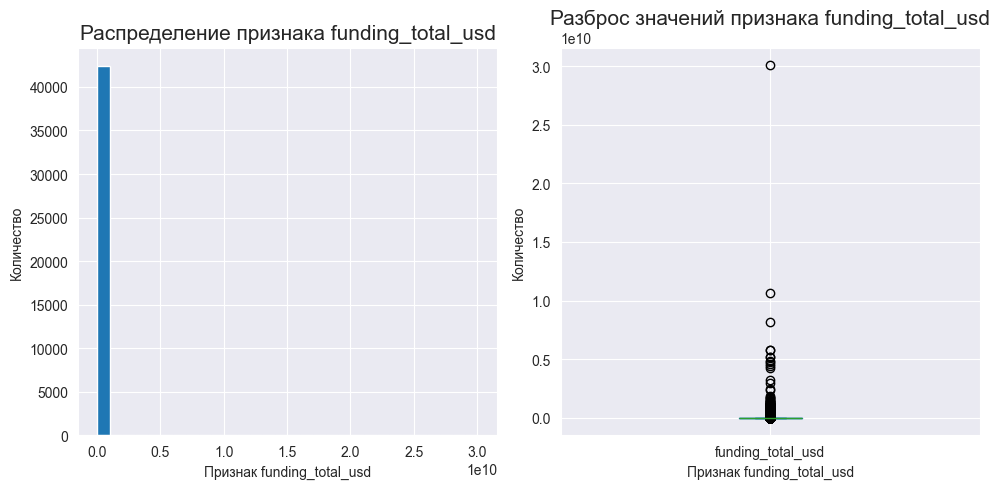

In [66]:
hist_num(data_train['funding_total_usd'], 'Распределение признака funding_total_usd', 'Разброс значений признака funding_total_usd', 'Признак funding_total_usd')

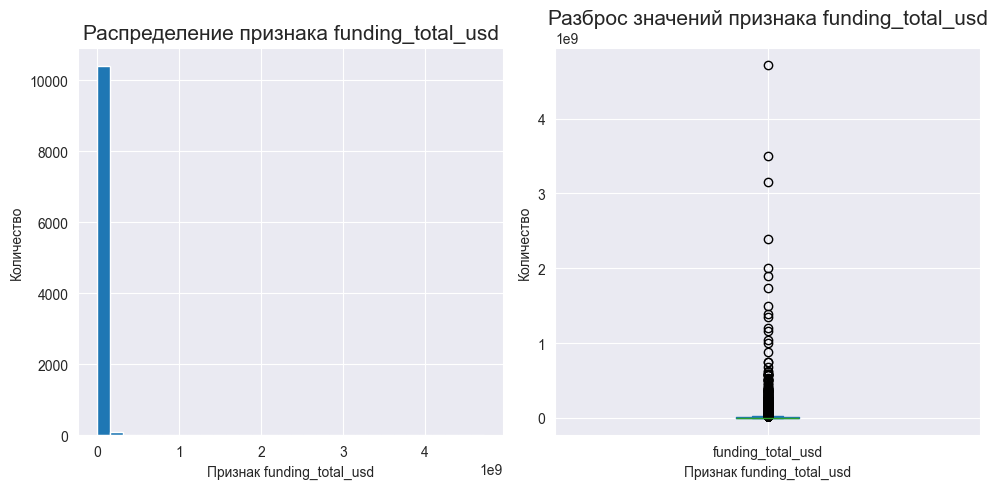

In [67]:
hist_num(data_test['funding_total_usd'], 'Распределение признака funding_total_usd', 'Разброс значений признака funding_total_usd', 'Признак funding_total_usd')

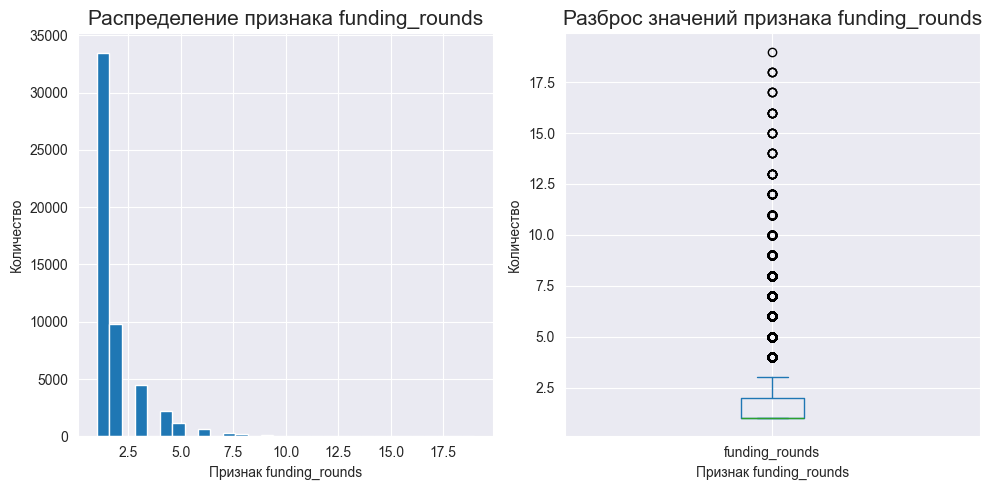

In [68]:
hist_num(data_train['funding_rounds'], 'Распределение признака funding_rounds', 'Разброс значений признака funding_rounds', 'Признак funding_rounds')

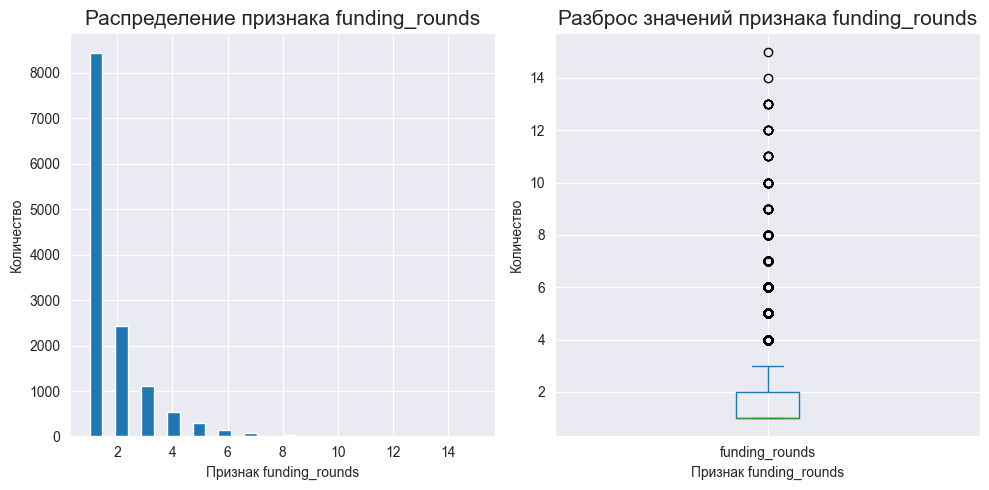

In [69]:
hist_num(data_test['funding_rounds'], 'Распределение признака funding_rounds', 'Разброс значений признака funding_rounds', 'Признак funding_rounds')

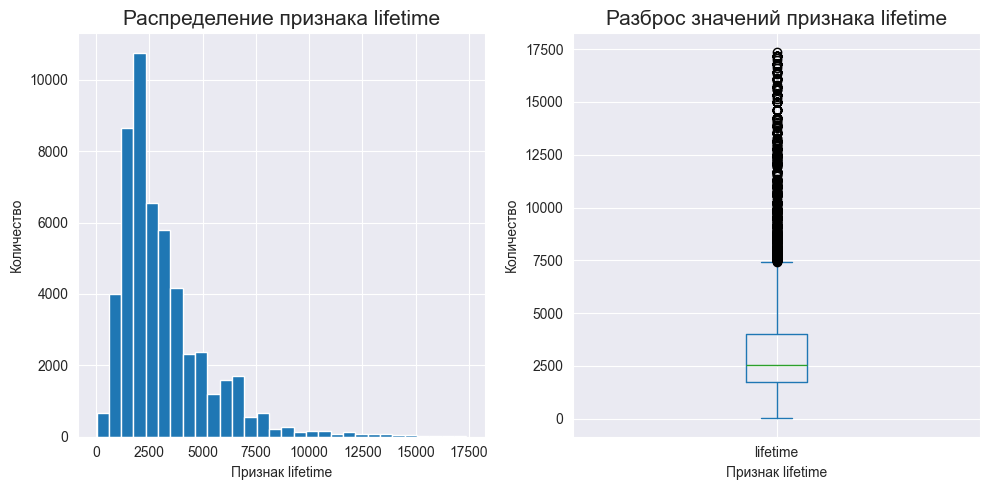

In [70]:
hist_num(data_train['lifetime'], 'Распределение признака lifetime', 'Разброс значений признака lifetime', 'Признак lifetime')

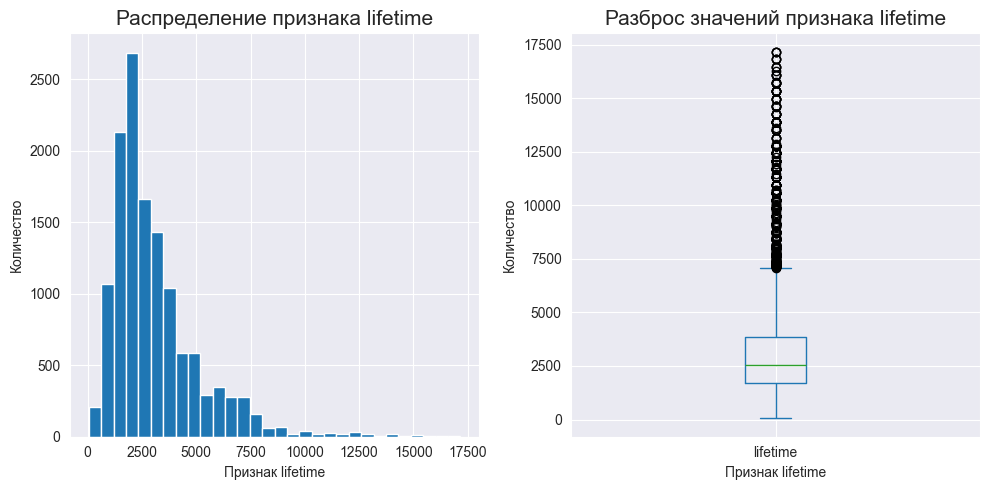

In [71]:
hist_num(data_test['lifetime'], 'Распределение признака lifetime', 'Разброс значений признака lifetime', 'Признак lifetime')

В данных наблюядается много выбросов. Это может повлиять на обучение модели. Поэтому создадим функцию которая будет по проценталю определять эти выбросы и заменять на медианное значение:

In [72]:
def num_median(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns   
    for col in numeric_cols:
        percentile_95 = data[col].quantile(0.95)
        median = data[col].median()
        data.loc[data[col] > percentile_95, col] = median

    return data

In [73]:
data_train_copy_1 = num_median(data_train_copy_1)


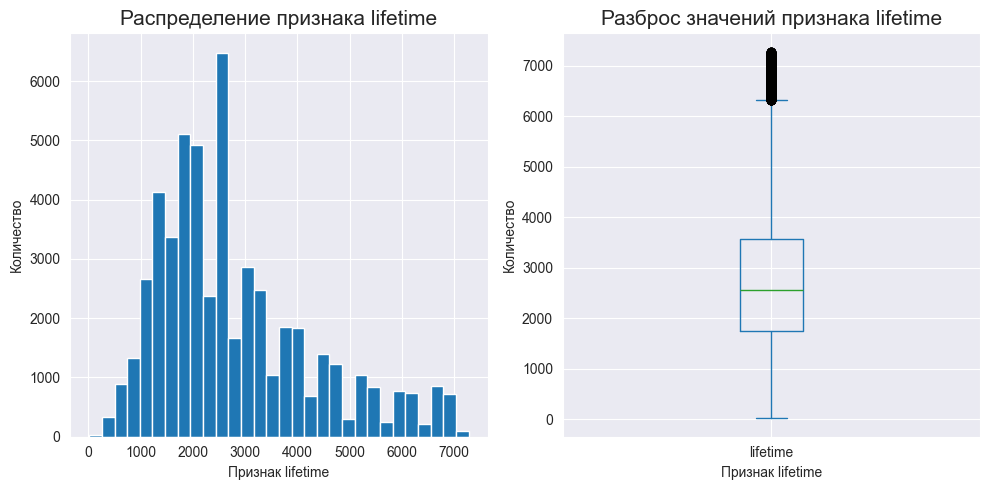

In [74]:
hist_num(data_train_copy_1['lifetime'], 'Распределение признака lifetime', 'Разброс значений признака lifetime', 'Признак lifetime')

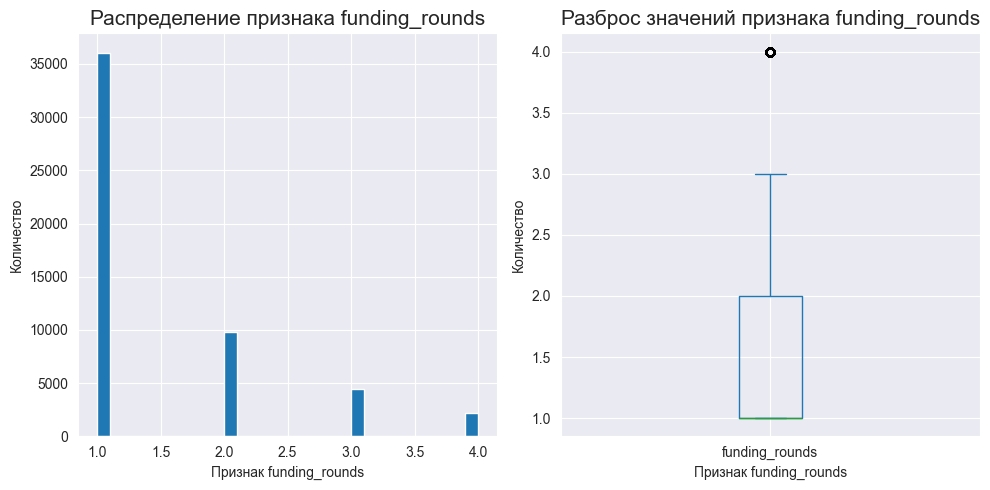

In [75]:
hist_num(data_train_copy_1['funding_rounds'], 'Распределение признака funding_rounds', 'Разброс значений признака funding_rounds', 'Признак funding_rounds')

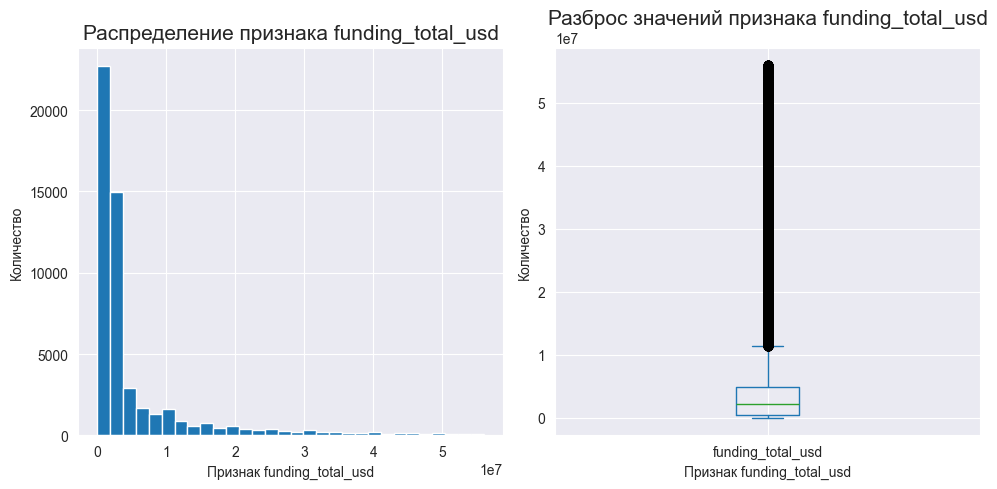

In [76]:
hist_num(data_train_copy_1['funding_total_usd'], 'Распределение признака funding_total_usd', 'Разброс значений признака funding_total_usd', 'Признак funding_total_usd')

Отлично, выбросы побеждены. Используем эту фунцию в дальнейшем в пайплайне. 

Теперь изучим время существования стартапа в зависимости от статуса:

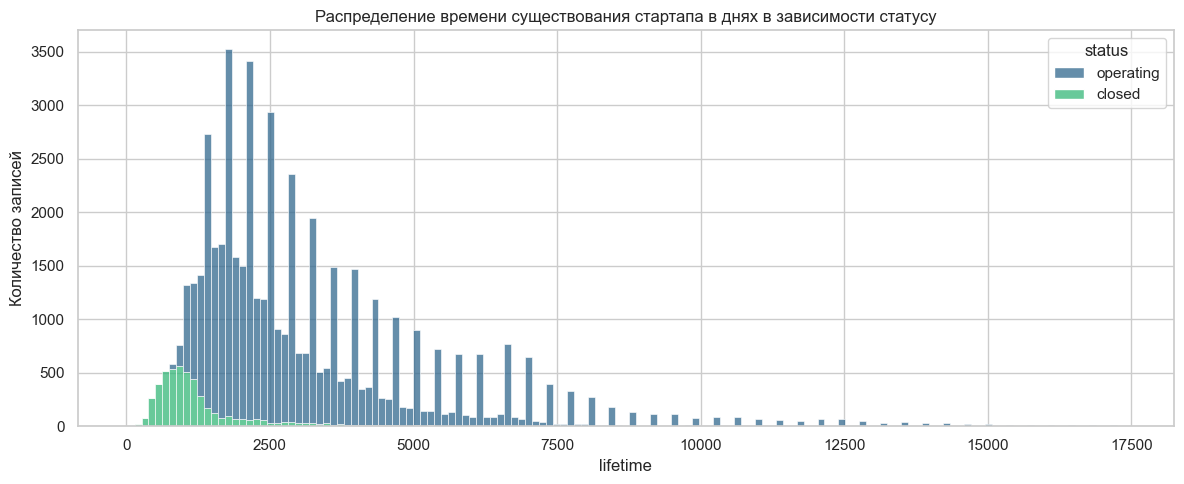

In [77]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 5))  

feature = "lifetime"
title = "Распределение времени существования стартапа в днях в зависимости статусу"

sns.histplot(data=df_train_copy_1, x=feature, hue="status", multiple="stack", ax=ax, palette="viridis")
ax.set_title(title)
ax.set_xlabel(feature)
ax.set_ylabel("Количество записей")

plt.tight_layout()
plt.show()

Из графика четко видно, что чем дольше живет стартап, тем шанс, что он закрыт - сокращается. Также есть выбросы, которые могут свидетельствовать о том, что есть определенные даты (сезонность) в которые чаще всего открывают стартапы.
Качественных признаков в любом случае много, поэтому их распределение мы смотреть не будем. Сразу приступим к добавлению новых признаков.

## 4 Создание новых признаков

Создадим признак, который будет определять уровень финансирования - низкий, средний или высокий.

In [78]:
data_train_copy_1['level_financing'] = pd.cut(
    data_train_copy_1['funding_total_usd'], bins=3, labels=['low', 'medium', 'high']
)

data_train_copy_1

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,stand_category,funding_day,continent,level_financing
0,Lunchgate,828626,operating,CHE,25,Zurich,Zürich,2,2998,online reservations,1310,Europe,low
1,EarLens,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,4748,manufacturing,1393,North America,high
2,Reviva Pharmaceuticals,35456381,operating,USA,CA,SF Bay Area,San Jose,3,4383,biotechnology,681,North America,medium
3,Sancilio and Company,22250000,operating,NaN,F7,Sydney,NaN,3,5114,health care,1051,Other,medium
4,WireTough Cylinders,3000000,operating,USA,VA,SF Bay Area,Bristol,1,2791,manufacturing,0,North America,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,2000000,operating,CAN,ON,Toronto,Kitchener,1,2192,entertainment,0,North America,low
52512,Hello Curry,500000,operating,IND,2,Bangalore,Hyderabad,1,1590,hospitality,0,Asia,low
52513,Taskforce,50000,operating,USA,CA,SF Bay Area,San Francisco,3,2741,email,566,North America,low
52514,NetScaler,13000000,operating,USA,CA,SF Bay Area,San Jose,1,2557,security,0,North America,low


Создадим функцию для нашего пайплайна:

In [79]:
def cat_funding(data):
    data['level_financing'] = pd.cut(
        data['funding_total_usd'], bins=3, labels=['low', 'medium', 'high'] 
    )
    return data

Также создадим бинарный признак, который будет определять стартапы, у которых 1 этап финасирования:

In [80]:
data_train_copy_1['single_funding_round'] = (data_train_copy_1['funding_rounds'] == 1).astype(int)
data_train_copy_1.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,stand_category,funding_day,continent,level_financing,single_funding_round
0,Lunchgate,828626,operating,CHE,25,Zurich,Zürich,2,2998,online reservations,1310,Europe,low,0
1,EarLens,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,4748,manufacturing,1393,North America,high,0
2,Reviva Pharmaceuticals,35456381,operating,USA,CA,SF Bay Area,San Jose,3,4383,biotechnology,681,North America,medium,0
3,Sancilio and Company,22250000,operating,NaN,F7,Sydney,NaN,3,5114,health care,1051,Other,medium,0
4,WireTough Cylinders,3000000,operating,USA,VA,SF Bay Area,Bristol,1,2791,manufacturing,0,North America,low,1


Напишем функцию для нашего пайплайна:

In [81]:
def single_funding_round(data):
    data['single_funding_round'] = (data['funding_rounds'] == 1).astype(int)
    return data

И наконец, перед созданием пайплайна и обучения моделей - проверим признаки на мультиколлиниарность. Для этого построим матрицу корреляции.

## Матрица корреляций

In [82]:
def phik(row, name):
    plt.figure(figsize=(8,8))
    sns.heatmap(row.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'funding_day']),
           vmax=1,
           square=True,
           annot=True,
           cmap='coolwarm',
           center=0,
           annot_kws={"size":8})
    plt.title(name)
    plt.show()

Разделим наш скопированный датасет, отделив от лишних признаков.

In [83]:
data_copy_corr =data_train_copy_1.drop(['name'], axis=1)
data_copy_corr_open = data_copy_corr[data_copy_corr['status'] == 'operating']
data_copy_corr_close = data_copy_corr[data_copy_corr['status'] == 'closed']

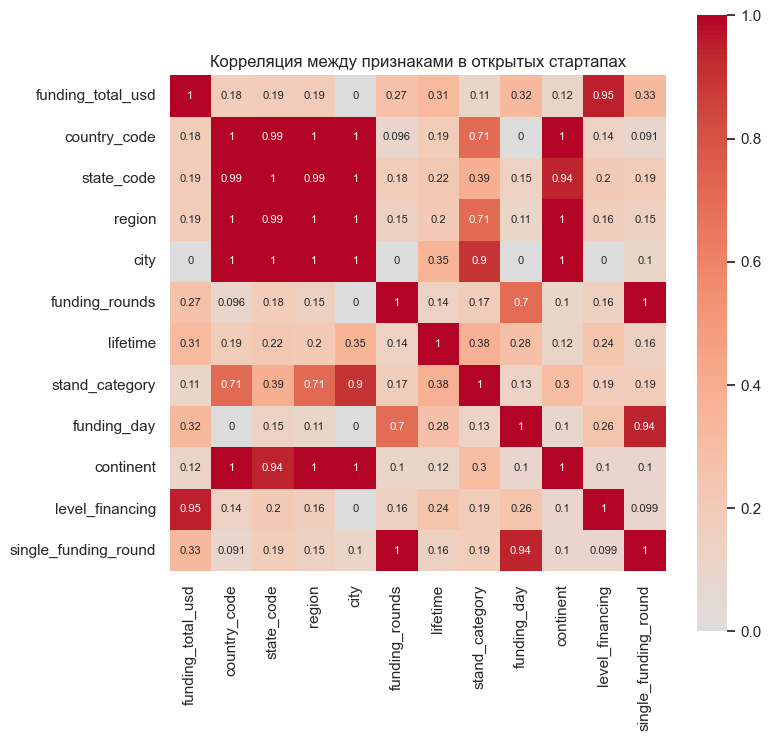

In [84]:
phik(data_copy_corr_open, 'Корреляция между признаками в открытых стартапах')

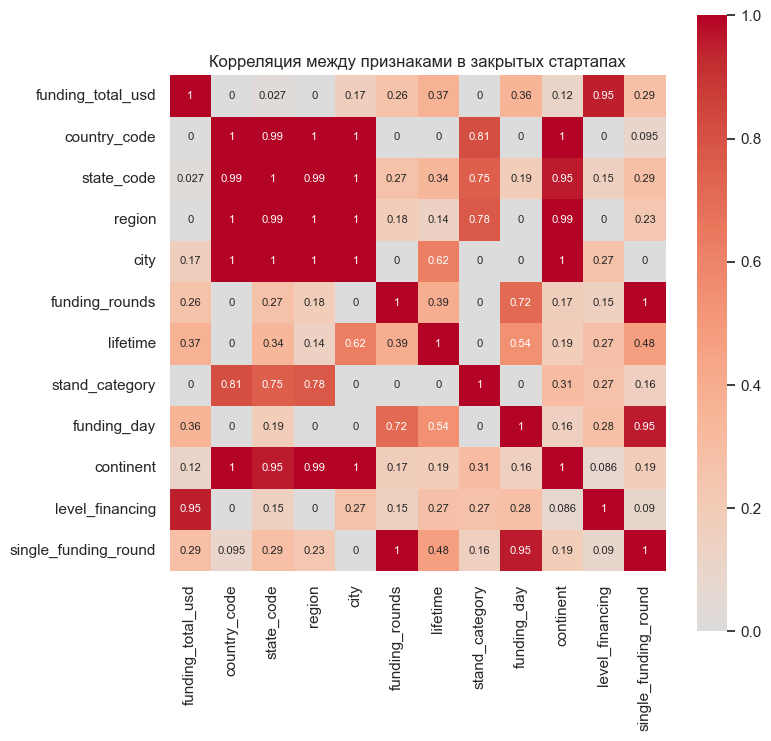

In [85]:
phik(data_copy_corr_close, 'Корреляция между признаками в закрытых стартапах')

Мультиколлиниарность есть. И есть она между признаками о географическом расположении и о количестве раундов, для того, чтоб избавиться от этого - создадим функцию для пайплайна:

In [86]:
def data_drop_columns(data):
    data = data.drop(['city', 'region', 'state_code', 'country_code', 'funding_rounds'], axis=1)
    return data

Прекрасно! Можно приступать к создадию пайплайна.

## 5 Пайплайн

In [87]:
leven_cat_transformer = FunctionTransformer(leven_cat, validate=False, kw_args={'create_mapping': True})
map_state_code_transformer = FunctionTransformer(map_state_code, validate=False)
del_other_region_transformer = FunctionTransformer(del_other_region, validate=False)
map_region_transformer = FunctionTransformer(map_region, validate=False)
funding_day_transformer = FunctionTransformer(funding_day, validate=False)
funding_total_usd_transformer = FunctionTransformer(funding_total_usd, validate=False)
stand_coun_cont_transformer = FunctionTransformer(stand_coun_cont, validate=False)
cat_funding_transformer = FunctionTransformer(cat_funding, validate=False)
num_median_transformer = FunctionTransformer(num_median, validate=False)
single_funding_round_transformer = FunctionTransformer(single_funding_round)
drop_columns_transformer = FunctionTransformer(data_drop_columns)

In [88]:
data_train_clean = data_train.drop(['name'], axis=1)
print('Количество дубликатов', data_train_clean.duplicated().sum())
data_train_clean = data_train_clean.drop_duplicates()
print('Количество дубликатов после отчистки', data_train_clean.duplicated().sum())

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

data_full = data_train_clean.copy()

label_encoder = LabelEncoder()

data_full['status'] = label_encoder.fit_transform(data_full['status'])

print("\nСвязь между значениями и кодами:")
for code, category in enumerate(label_encoder.classes_):
    print(f"Код {code}: Значение '{category}'")
print(LINE_1)

X_train, X_valid, y_train, y_valid = train_test_split(
    data_full.drop(['status'], axis=1),
    data_full['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_full['status'])
print(X_train.shape, X_valid.shape)
print(LINE_1)
y_train.shape, y_valid.shape

Количество дубликатов 10
Количество дубликатов после отчистки 0

Связь между значениями и кодами:
Код 0: Значение 'closed'
Код 1: Значение 'operating'
-----------------------------------------------------------------------------------------------------------------------------
(39379, 10) (13127, 10)
-----------------------------------------------------------------------------------------------------------------------------


((39379,), (13127,))

In [92]:
X_train

,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
7103,Aerospace|Drones|Transportation,182172.0,USA,WA,Seattle,Seattle,2,2015-02-11,2015-02-11,2881
48980,Postal and Courier Services,111111.0,AUS,2,Sydney,Sydney,1,2014-04-02,2014-04-02,1356
14269,Services,22100000.0,USA,IL,Chicago,Chicago,1,2014-11-12,2014-11-12,7305
20469,NaN,NaN,ISR,5,Tel Aviv,Tel Aviv,1,2015-06-01,2015-06-01,1461
18376,Mobile|Software|Travel,1814010.0,USA,IL,Chicago,Chicago,2,2014-07-29,2015-06-15,2192
...,...,...,...,...,...,...,...,...,...,...
50363,Location Based Services|Social Media|Sports,217000.0,USA,CA,Los Angeles,Woodland Hills,2,2011-11-13,2011-11-19,2508
5235,Communities|Education|Enterprise Software|Know...,1845836.0,USA,CA,SF Bay Area,San Francisco,3,2010-03-01,2013-04-01,2402
35384,Biotechnology,5550000.0,NaN,NaN,NaN,NaN,3,2011-12-27,2012-04-04,2815
5337,E-Commerce,10000000.0,USA,MN,Minneapolis,Saint Paul,1,2011-11-10,2011-11-10,8858


In [97]:
ord_columns = ['stand_category',
               'continent', 'single_funding_round']
ohe_columns = [ 'level_financing']
num_columns = ['funding_total_usd',
               'funding_day', 'lifetime']

In [98]:
def pipe_line(ohe_columns, ord_columns, num_columns):
    global pipe_final
    
    preprocessing_pipeline = Pipeline([
    ('leven_cat_transformer', leven_cat_transformer),
    ('map_state_code_transformer', map_state_code_transformer),
    ('del_other_region_transformer', del_other_region_transformer),
    ('map_region_transformer', map_region_transformer),
    ('funding_day_transformer', funding_day_transformer),
    ('funding_total_usd_transformer', funding_total_usd_transformer),
    ('stand_coun_cont_transformer', stand_coun_cont_transformer),
    ('cat_funding_transformer', cat_funding_transformer),
    ('num_median_transformer', num_median_transformer),
    ('single_funding_round', single_funding_round_transformer),
    ('drop_columns', drop_columns_transformer)
    ])
    
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')  
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  
            )
        ]
    )

    ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord',  
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')  
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',  
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
        )
    ])  

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),  
            ('num', MinMaxScaler(), num_columns)
        ],
        remainder='passthrough'  
    )

    pipe_final = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression()) 
    ])
    
pipe_line(ohe_columns, ord_columns, num_columns)

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [101]:
grid_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=50,
    cv=stratified_cv,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('leven_cat_transformer',
                                                               FunctionTransformer(func=<function leven_cat at 0x000001616D8D3A60>,
                                                                                   kw_args={'create_mapping': True})),
                                                              ('map_state_code_transformer',
                                                               FunctionTransformer(func=<function map_state_code at 0x000001...
                                         'models__max_features': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=45,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 6),
                                         'models__class_weight': [None,
                                                                  'balanced'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='f1')

In [115]:
result_data = pd.DataFrame(grid_search.cv_results_)
display(result_data[['rank_test_score','std_test_score', 'param_models', 'mean_test_score', 'params']].sort_values('rank_test_score').head(10))
print('Лучшая модель и её параметры: \n\n', grid_search.best_estimator_)
print('Параметры лучшей модели:', grid_search.best_params_)
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', grid_search.best_score_)

,rank_test_score,std_test_score,param_models,mean_test_score,params
46,1,0.001347,DecisionTreeClassifier(random_state=45),0.972142,"{'preprocessor__num': 'passthrough', 'models__..."
33,1,0.001347,DecisionTreeClassifier(random_state=45),0.972142,"{'preprocessor__num': MinMaxScaler(), 'models_..."
28,1,0.001347,DecisionTreeClassifier(random_state=45),0.972142,"{'preprocessor__num': StandardScaler(), 'model..."
18,4,0.001780,DecisionTreeClassifier(random_state=45),0.969946,"{'preprocessor__num': StandardScaler(), 'model..."
35,5,0.002567,DecisionTreeClassifier(random_state=45),0.969686,"{'preprocessor__num': 'passthrough', 'models__..."
34,6,0.002574,DecisionTreeClassifier(random_state=45),0.969657,"{'preprocessor__num': StandardScaler(), 'model..."
2,7,0.002575,DecisionTreeClassifier(random_state=45),0.969633,"{'preprocessor__num': MinMaxScaler(), 'models_..."
11,8,0.001044,DecisionTreeClassifier(random_state=45),0.968080,"{'preprocessor__num': MinMaxScaler(), 'models_..."
15,9,0.000632,"LogisticRegression(penalty='l1', random_state=...",0.968057,"{'preprocessor__num': StandardScaler(), 'model..."
7,10,0.000648,"LogisticRegression(penalty='l1', random_state=...",0.968046,"{'preprocessor__num': MinMaxScaler(), 'models_..."


Лучшая модель и её параметры: 

 Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('leven_cat_transformer',
                                  FunctionTransformer(func=<function leven_cat at 0x000001616D8D3A60>,
                                                      kw_args={'create_mapping': True})),
                                 ('map_state_code_transformer',
                                  FunctionTransformer(func=<function map_state_code at 0x000001616C8B02C0>)),
                                 ('del_other_region_transformer',
                                  FunctionTransformer(func=<function del_other...
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                

In [157]:
y_pred_valid = grid_search.best_estimator_.predict(X_valid)
f1 = f1_score(y_valid, y_pred, pos_label=1)
print(f'F1-score равен {f1}')

F1-score равен 0.971913133402275


Отлично, на валидационных данных реузльтат почти не отличается от результата на валидационных. Можно приступать к анализу важности признаков.

In [144]:
import shap
best_model = grid_search.best_estimator_.named_steps['models']
preprocessor = grid_search.best_estimator_.named_steps['preprocessing']
preprocessor_pre = grid_search.best_estimator_.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)
X_train_transformed = preprocessor_pre.transform(X_train_transformed)
X_valid_transformed = preprocessor.transform(X_valid)
X_valid_transformed = preprocessor_pre.transform(X_valid_transformed)
def get_feature_names(transformer, input_features=None):
    output_features=[]
    for name, pipe, features in transformer.transformers_:
        if name =='remainder':
            output_features.extend(input_features[features])
        else:
            if hasattr(pipe, 'get_feature_names_out'):
                feature_names = pipe.get_feature_names_out(features)
            elif hasattr(pipe, 'get_feature_names'):
                feature_names = pipe.get_feature_names(features)
            else:
                feature_names = features
            output_features.extend(feature_names)
    return output_features
feature_names = get_feature_names(preprocessor_pre, input_features=X_train.columns.tolist())


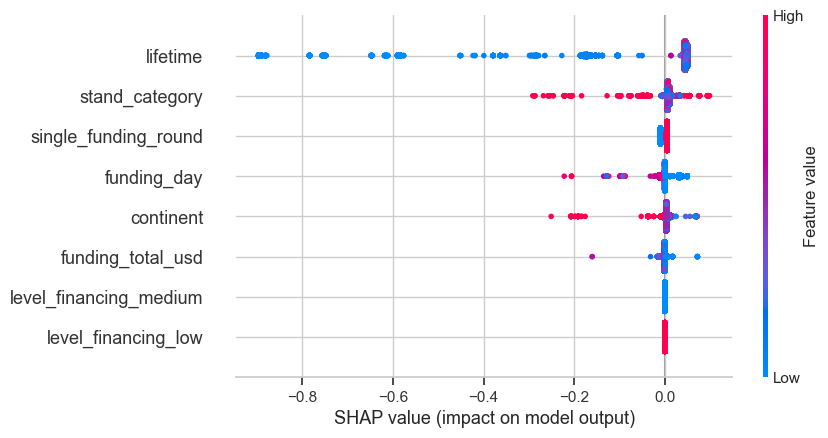

In [156]:
explainer = shap.Explainer(best_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_valid_transformed)
shap.plots.beeswarm(shap_values[:,:,1])


Таким образом, что изменение и стандартизация категории очень помогла и она имела высокое на влияние на принятие решения. Также важным признаком оказалось отношение к континенту. Продолжительность жизни стартапа также виляла на то, какое решение примет модель.

## Выгрузка данных

In [158]:
data_test_final = data_test.copy()
data_test_final['predict_status'] = grid_search.best_estimator_.predict(data_test_final)

In [159]:
data_test_final['status'] = label_encoder.inverse_transform(data_test_final['predict_status'])

In [160]:
data_final = data_test_final[['name', 'status']]
data_final.to_csv('final_predictions.csv', index=False)

print("Файл сохранен как 'final_predictions.csv'.")

Файл сохранен как 'final_predictions.csv'.
